In [29]:
using PyPlot, Random
using OptimalTransport #for exact OT computation
using Tulip; #for exact OT computation;

In [2]:
function ProjectionPlan(p, q, γ) # projection algorithm (alg. 3) by Altschuler et al.
    m, n = length(p), length(q)
    a = min.(p ./ sum(γ, dims=2), 1)
    γ_temp = a .* γ
    b = min.(q ./ sum(γ, dims=1)', 1)
    γ_temp = γ_temp .* b'
    Δp = p .- sum(γ_temp, dims=2)
    Δq = q .- sum(γ_temp, dims=1)'
    γ_plan = γ_temp .+ Δp .* Δq' / sum(Δp)
    return γ_plan
end

ProjectionPlan (generic function with 1 method)

In [4]:
# Annealed Sinkhorn algorithm with a few tracking functionalities
function Sinkhorn_track(p, q, c; niter=100, OT_cost=0.0, κ = 0.0, β0 = 1.0, debiased = true, iter_stop=niter, plateau_length=1)
    m, n = length(p), length(q)
    @assert (m,n)==size(c)
    u,v = zeros(m), zeros(n)'
    lp, lq = log.(p), log.(q)'
    plans = zeros(m, n, niter)
    proj_plans = zeros(m, n, niter)
    err = zeros(niter)
    β = β0
    for t = 1:niter
        if debiased && (t <= iter_stop)
            temp1 = (lq .+ v .- β*c)  .- ((t^κ-(t-1)^κ)/t^κ) .* (u)
        else
            temp1 = v .+ lq .- β*c
        end
        stab1 = maximum(temp1, dims = 2)
        u = - stab1 .- log.(sum(exp.(temp1 .- stab1), dims = 2))
        if (t <= iter_stop) && mod(Int(floor(sqrt(t))),plateau_length)==0
            β = β0 * ((t+1)^κ)
        end
        temp2 = u .+ lp .- β*c
        stab2 = maximum(temp2, dims = 1)
        v = - stab2 .- log.(sum(exp.(temp2 .- stab2), dims = 1))
        plans[:,:,t] = exp.(u .+ lp .+ v .+ lq .- β*c)
        proj_plans[:,:,t] = ProjectionPlan(p, q, plans[:,:,t] )
        err[t] = sum(c .* proj_plans[:,:,t]) - OT_cost
    end
    return plans, err
end

Sinkhorn_track (generic function with 1 method)

# Setting 1 : unstructure cost

In [3]:
Random.seed!(1)
m, n = 75,75
p, q = rand(m), rand(n);
p = p/sum(p)
q = q/sum(q);
# Case: random cost
c = randn(m,n);
c = c/(maximum(c)-minimum(c));
plan_opt = emd(p, q, c, Tulip.Optimizer());
OT_cost=sum(c .* plan_opt);

# Setting 2: geometric cost

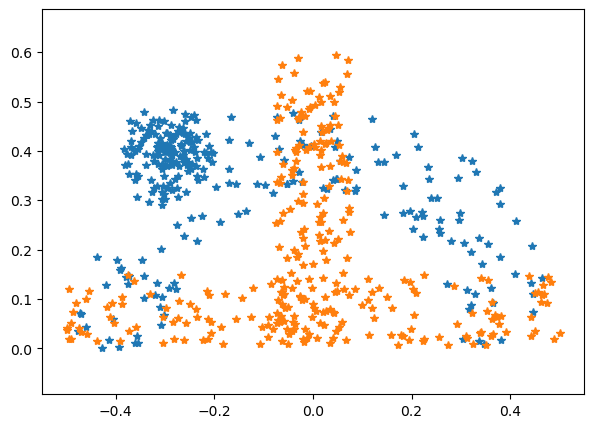

0.07434832077851553

In [14]:
Random.seed!(1)
# First measure
m = 150
ang = rand(m)*π
rad = rand(m)*0.2 .+ 0.3
X1 = cat(rad .* cos.(ang), rad .* sin.(ang), dims=2)
m = 150
ang = rand(m)*2π
rad = rand(m)*0.1
X2 = cat(rad .* cos.(ang) .- 0.3, rad .* sin.(ang) .+0.4, dims=2)
X = cat(X1, X2, dims=1)

figure(figsize=[7,5])
plot(X[:,1], X[:,2],"*")
axis("equal")

n = 150
Y1 = cat(rand(n) .- 0.5, rand(n).*0.15, dims=2)
n = 150
Y2 = cat((rand(n) .- 0.5)*0.15, rand(n)*0.6, dims=2)
Y = cat(Y1, Y2, dims=1)
plot(Y[:,1], Y[:,2],"*")
#axis([-0.55,0.55,0,0.65])
#savefig("geometric-data.png",bbox_inches="tight",dpi=200)

m,n = size(X,1), size(Y,1)
p = ones(m)/m
q = ones(n)/n
c = [ sum((X[i,:] .- Y[j,:]).^2) for i=1:m , j=1:n];
c = c/(maximum(c)-minimum(c));

plan_opt = emd(p, q, c, Tulip.Optimizer());
OT_cost=sum(c .* plan_opt)

# Pareto front experiments

Choose the setting 1 or 2 above by running the respective code blocks.

In [5]:
niter = 1000
β0 = 10
.., err1 = Sinkhorn_track(p,q,c, niter=niter, OT_cost=OT_cost,  κ = 1/2, β0 = β0, debiased = false);
.., err2 = Sinkhorn_track(p,q,c, niter=niter, OT_cost=OT_cost,  κ = 2/3, β0 = β0, debiased = true);
β0s = 10 .^ (1:0.1:3)
err_tab = zeros(niter,length(β0s))
for k = 1:length(β0s)
      .., err_tab[:,k] = Sinkhorn_track(p,q,c, niter=niter, OT_cost=OT_cost,  κ = 0.0, β0 = β0s[k], debiased = true);
end

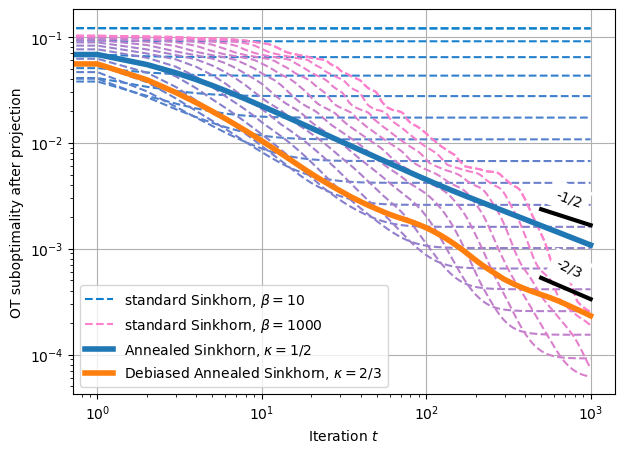

In [6]:
figure(figsize=[7,5])
loglog(err_tab[:,1] ,color=[1/length(β0s) 0.5 0.8],"--",label=L"standard Sinkhorn, $\beta=10$")
loglog(err_tab[:,end] ,color=[1 0.5 0.8],"--",label=L"standard Sinkhorn, $\beta=1000$")
for k= 1:length(β0s)
    loglog(err_tab[:,k] ,color=[k/length(β0s) 0.5 0.8],"--")
end

loglog(err1 ,label=L"Annealed Sinkhorn, $\kappa=1/2$",lw=4)
loglog(err2 ,label=L"Debiased Annealed Sinkhorn, $\kappa=2/3$",lw=4)
text(600,0.0025,"-1/2",color="black",size=10,backgroundcolor="white",rotation=-20)
plot(500:10:1000, (500:10:1000).^(-1/2)/19,"k",lw=3)
text(600,0.00054,"-2/3",color="black",size=10,backgroundcolor="white",rotation=-25)
plot(500:10:1000, (500:10:1000).^(-2/3)/30,"k",lw=3)
legend()
xlabel(L"Iteration $t$")
ylabel("OT suboptimality after projection")
grid("on")
#savefig("pareto-front-rnd.png",bbox_inches="tight",dpi=200)

# Error as a function of scaling exponent

In [15]:
niter = 200
β0 = 10
κs = range(0.1,1,length=30)
err_tab1 = zeros(length(κs))
err_tab2 = zeros(length(κs))
@time for k = 1:length(κs)
    path, err = Sinkhorn_track(p,q,c, niter=niter, OT_cost=OT_cost,  κ = κs[k], β0 = β0, debiased = false);
    err_tab1[k] =  err[end] #sum(abs.(sum(path[:,:,end],dims=2) .- p)) #error on marginal
    path, err = Sinkhorn_track(p,q,c, niter=niter, OT_cost=OT_cost,  κ = κs[k], β0 = β0, debiased = true);
    err_tab2[k] = err[end]
end

 48.848102 seconds (1.38 M allocations: 145.333 GiB, 14.22% gc time)


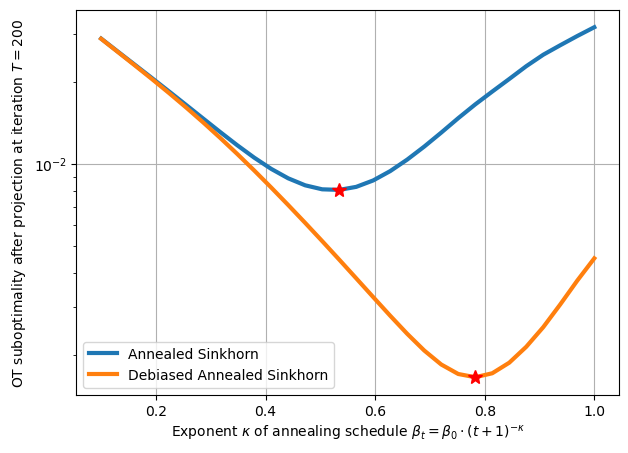

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7fdf03b2d9a0>

In [16]:
figure(figsize=[7,5])
semilogy(κs, err_tab1,label="Annealed Sinkhorn",lw=3)
semilogy(κs, err_tab2,label="Debiased Annealed Sinkhorn",lw=3)
legend()
xlabel(L"Exponent $\kappa$ of annealing schedule $\beta_t=\beta_0\cdot(t+1)^{-\kappa}$")
ylabel(L"OT suboptimality after projection at iteration $T=200$ ")
grid("on")
..,I = findmin(err_tab1)
plot(κs[I], err_tab1[I],"r*",ms=10)
..,I = findmin(err_tab2)
plot(κs[I], err_tab2[I],"r*",ms=10)

#savefig("schedule-comparison.png",bbox_inches="tight",dpi=200)

# Piece-wise constant schedules

In [ ]:
niter = 1000

.., err1 = Sinkhorn_track(p,q,c, niter=niter, OT_cost=OT_cost,  κ = 1/2, β0 = 10, debiased = false, plateau_length = 1);
.., err2 = Sinkhorn_track(p,q,c, niter=niter, OT_cost=OT_cost,  κ = 1/2, β0 = 10, debiased = false, plateau_length = 5);

.., errb1 = Sinkhorn_track(p,q,c, niter=niter, OT_cost=OT_cost,  κ = 3/4, β0 = 10, debiased = false, plateau_length = 1);
.., errb2 = Sinkhorn_track(p,q,c, niter=niter, OT_cost=OT_cost,  κ = 3/4, β0 = 10, debiased = false, plateau_length = 8);

.., errc1= Sinkhorn_track(p,q,c, niter=niter, OT_cost=OT_cost,  κ = 2/3, β0 = 10, debiased = true, plateau_length = 1);

.., errd1= Sinkhorn_track(p,q,c, niter=niter, OT_cost=OT_cost,  κ = 1, β0 = 10, debiased = false, plateau_length = 1);
.., errd2= Sinkhorn_track(p,q,c, niter=niter, OT_cost=OT_cost,  κ = 1, β0 = 10, debiased = false, plateau_length = 12);

In [ ]:
figure(figsize=[7,5])
loglog(err1,"C0",label=L"\kappa=1/2",lw=3)
semilogy(err2,"C0--",label=L"$\kappa=1/2$ (piecewise cst)")

semilogy(errb1,"C1",label=L"\kappa=3/4",lw=3)
semilogy(errb2,"C1--",label=L"$\kappa=3/4$ (piecewise cst)")

semilogy(errc1,"C3",label=L"$\kappa=2/3$ (debiased)",lw=3)

xlabel(L"Iteration $t$")
ylabel("OT suboptimality after projection")
grid("on")
legend()
#savefig("piecewise-constant.png",bbox_inches="tight",dpi=200)

# Symmetric Sinkhorn

In [ ]:
function sinkhorn_symmetric_track(p, q, c; niter=100, OT_cost=0.0, κ = 0.0, β0 = 1.0, debiased = true, iter_stop=niter, plateau_length=1)
    m, n = length(p), length(q)
    @assert (m,n)==size(c)
    u,v = zeros(m), zeros(n)'
    lp, lq = log.(p), log.(q)'
    plans = zeros(m, n, niter)
    proj_plans = zeros(m, n, niter)
    err = zeros(niter)
    β = β0
    for t = 1:niter
        θ = (debiased ? (1-((t-1)^κ)/t^κ) : 0.0)
        temp1 = v .- β*c 
        stab1 = maximum(temp1, dims =2)
        uu = (0.5 + θ)* u + 0.5* lp - 0.5*(stab1 .+ log.(sum(exp.(temp1 .- stab1), dims = 2)))
        temp2 = u .- β*c
        stab2 = maximum(temp2, dims = 1)
        vv = (0.5 + θ)* v + 0.5* lq - 0.5*(stab2 .+ log.(sum(exp.(temp2 .- stab2), dims = 1)))
        u, v = uu, vv
        plans[:,:,t] = exp.(u .+ v .- β*c)
        plans[:,:,t] = plans[:,:,t]./sum(plans[:,:,t])
        proj_plans[:,:,t] = ProjectionPlan(p, q, plans[:,:,t] )
        err[t] = sum(c .* proj_plans[:,:,t]) - OT_cost
        if (t <= iter_stop) && mod(Int(floor(sqrt(t))),plateau_length)==0
            β = β0 * ((t+1)^κ)
        end
    end
    return plans, err
end

In [ ]:
niter = 1000
path1, err1 = Sinkhorn_track(p,q,c, niter=niter, OT_cost=OT_cost,  κ = 1/2, β0 = 10, debiased = false);
path2, err2 = sinkhorn_symmetric_track(p, q, c; niter=niter, OT_cost=OT_cost, κ = 1/2, β0 = 10, debiased = false);
path11, err11 = Sinkhorn_track(p,q,c, niter=niter, OT_cost=OT_cost,  κ = 2/3, β0 = 10, debiased = true);
path22, err22 = sinkhorn_symmetric_track(p, q, c; niter=niter, OT_cost=OT_cost, κ = 2/3, β0 = 10, debiased = true);

In [ ]:
figure(figsize=[7,5])
loglog(err1,label="Annealed Sinkhorn (AS)",lw=3)
plot(err2,label="Symmetric AS",lw=3)
plot(err11,label="Debiased AS",lw=3)
plot(err22,label="Debiased Symmetric AS",lw=3)
legend()
xlabel(L"Iteration $t$")
ylabel("OT suboptimality after projection")
grid("on")
#savefig("symmetric-vs-not.png",bbox_inches="tight",dpi=200)

# Comparison optim vs proxy path

Compute the solution to the proxy path, for given parameters $\alpha$ and $\beta$: $$\min \langle c,\pi\rangle +\frac{1}{\alpha}KL(\pi^\top \mathbf{1}|p)+\iota_{\{q\}}(\pi^\top \mathbf{1}) +\frac{1}{\beta}KL(\pi,\pi^{\mathbf{ref}})$$
where $\pi^{\mathbf{ref}}=(mn)^{-1}\mathbf{1}\mathbf{1}^\top$
We perform alternate maximization on the dual problem, as in Chizat et al. 2016. The equations are as follows:
$$
K=e^{-\beta c}\pi^{\mathbf{ref}}, \quad a_{t+1} = \Big( \frac{p}{Kb_t}\Big)^{\beta/(\beta+\alpha)}, \quad b_{t+1} = \frac{q}{K^\top a_{t+1}}.
$$
and we return the plan $\pi_t=\mathrm{diag}(a_t)K\mathrm{diag}(b_t)$. Let's implement this function in log domain, with $u_t=\log(a_t \oslash p)$ and $v_t=\log(b_t\oslash q)$. Since we have a hard marginal constraint, we can ignore $\pi^{\mathrm{ref}}$.

In [17]:
function proxy_path_step(p, q, c, α, β, u_init, v_init; niter=10)
    m, n = length(p), length(q)
    @assert (m,n)==size(c)
    #u,v = zeros(m), zeros(n)'
    u, v = u_init, v_init # for warm start
    lp, lq = log.(p), log.(q)'
    θ = β / (α + β)
    for t=1:niter
        temp1 = v .+ lq .- β*c
        stab1 = maximum(temp1, dims = 2)
        u = (- stab1 .- log.(sum(exp.(temp1 .- stab1), dims = 2)))*θ + (θ-1)*lp
        temp2 = u .+ lp .- β*c
        stab2 = maximum(temp2, dims = 1)
        v = - stab2 .- log.(sum(exp.(temp2 .- stab2), dims = 1))
    end
    return exp.(u .+ lp .+ v .+ lq .- β*c), u, v
end

proxy_path_step (generic function with 1 method)

In [18]:
function proxy_path(p, q, c, αs, βs)
    T = length(αs)
    m, n = length(p), length(q)
    path = zeros(m,n,T)
    u,v = zeros(m), zeros(n)'
    niter = 100
    for t = 1:T
        path[:,:,t],u,v = proxy_path_step(p, q, c, αs[t], βs[t], u, v; niter=niter)
    niter = 50
    end
return path
end

proxy_path (generic function with 1 method)

In [19]:
function Sinkhorn_path(p, q, c; niter=100, κ = 0.0, β0 = 1.0, debiased = true)
    m, n = length(p), length(q)
    @assert (m,n)==size(c)
    u,v = zeros(m), zeros(n)'
    lp, lq = log.(p), log.(q)'
    path = zeros(m, n, niter)
    βs = zeros(niter)
    β = β0
    for t = 1:niter
        βs[t] = β
        if debiased 
            temp1 = (lq .+ v .- β*c)  .- ((t^κ-(t-1)^κ)/t^κ) .* (u)
        else
            temp1 = v .+ lq .- β*c
        end
        stab1 = maximum(temp1, dims = 2)
        u = - stab1 .- log.(sum(exp.(temp1 .- stab1), dims = 2))
        β = β0 * ((t+1)^κ)
        temp2 = u .+ lp .- β*c
        stab2 = maximum(temp2, dims = 1)
        v = - stab2 .- log.(sum(exp.(temp2 .- stab2), dims = 1))
        path[:,:,t] = exp.(u .+ lp .+ v .+ lq .- β*c)
    end
    return path, βs
end

Sinkhorn_path (generic function with 1 method)

In [20]:
niter = 1000
# schedule 1
opti_path, βs = Sinkhorn_path(p, q, c, niter=niter, κ = 1/2, β0 = 10.0, debiased = false);
αs = βs[2:end] .- βs[1:end-1]
@time prox_path = proxy_path(p, q, c, αs, βs[1:end-1]);

 80.050076 seconds (4.60 M allocations: 204.658 GiB, 0.38% gc time, 1.57% compilation time)


In [21]:
# schedule 2
opti_path2, βs = Sinkhorn_path(p, q, c, niter=niter, κ = 1/4, β0 = 10.0, debiased = false);
αs = βs[2:end] .- βs[1:end-1]
@time prox_path2 = proxy_path(p, q, c, αs, βs[1:end-1]);

 83.633632 seconds (2.06 M allocations: 204.536 GiB, 5.30% gc time)


In [22]:
# schedule 3
opti_path3, βs = Sinkhorn_path(p, q, c, niter=niter, κ = 3/4, β0 = 10.0, debiased = false);
αs = βs[2:end] .- βs[1:end-1]
@time prox_path3 = proxy_path(p, q, c, αs, βs[1:end-1]);

 84.626704 seconds (2.06 M allocations: 204.536 GiB, 5.21% gc time)


In [23]:
plan_opt = emd(p, q, c, Tulip.Optimizer());
pp1 = [sum(abs.(sum(prox_path2[:,:,t], dims =2) .- p)) for t=1:niter-1]
pp2 = [sum(abs.(sum(opti_path2[:,:,t], dims =2) .- p)) for t=1:niter-1]
pp3 = [sum(abs.(sum(opti_path2[:,:,t], dims =2) .- sum(prox_path2[:,:,t], dims =2))) for t=1:niter-1]

qq1 = [sum(abs.(sum(prox_path[:,:,t], dims =2) .- p)) for t=1:niter-1]
qq2 = [sum(abs.(sum(opti_path[:,:,t], dims =2) .- p)) for t=1:niter-1]
qq3 = [sum(abs.(sum(opti_path[:,:,t], dims =2) .- sum(prox_path[:,:,t], dims =2))) for t=1:niter-1]

rr1 = [sum(abs.(sum(prox_path3[:,:,t], dims =2) .- p)) for t=1:niter-1]
rr2 = [sum(abs.(sum(opti_path3[:,:,t], dims =2) .- p)) for t=1:niter-1]
rr3 = [sum(abs.(sum(opti_path3[:,:,t], dims =2) .- sum(prox_path3[:,:,t], dims =2))) for t=1:niter-1];

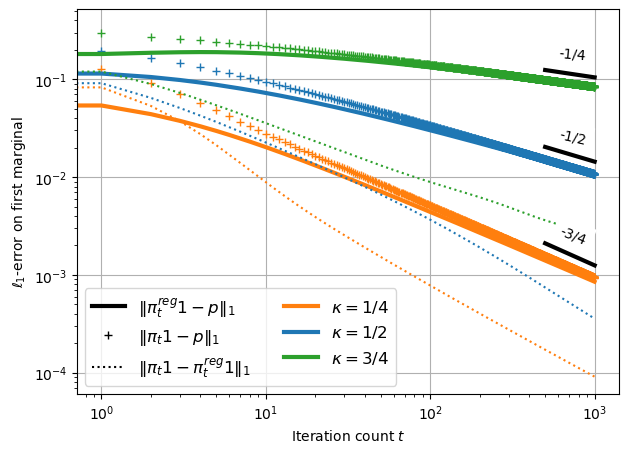

In [28]:
figure(figsize=[7,5])
# for the legend
loglog([sum(abs.(sum(prox_path2[:,:,t], dims =2) .- p)) for t=1:1],label=L"\Vert \pi_t^{reg} 1-p\Vert_1","k",lw=3)
plot([sum(abs.(sum(opti_path2[:,:,t], dims =2) .- p)) for t=1:1],"k+",label=L"\Vert \pi_t 1-p\Vert_1")
plot([sum(abs.(sum(opti_path2[:,:,t], dims =2) .- sum(prox_path2[:,:,t], dims =2))) for t=1:1],":k",label=L"\Vert \pi_t 1-\pi_t^{reg} 1\Vert_1")

loglog(pp1,label=L"\kappa=1/4","C1",lw=3)
plot(pp2,"C1+")
plot(pp3,":C1")

loglog(qq1,"C0",label=L"\kappa=1/2",lw=3)
plot(qq2,"C0+")
plot(qq3,":C0")

loglog(rr1,label=L"\kappa=3/4","C2",lw=3)
plot(rr2,"C2+")
plot(rr3,":C2")

text(600,0.16,"-1/4",color="black",size=10,backgroundcolor="white",rotation=-5)
plot(500:10:1000, (500:10:1000).^(-1/4)/1.7,"k",lw=3)

text(600,0.022,"-1/2",color="black",size=10,backgroundcolor="white",rotation=-13)
plot(500:10:1000, (500:10:1000).^(-1/2)/2.2,"k",lw=3)

text(600,0.0021,"-3/4",color="black",size=10,backgroundcolor="white",rotation=-22)
plot(500:10:1000, (500:10:1000).^(-3/4)/4.5,"k",lw=3)

legend(ncol=2,fontsize="large")
grid("on")
xlabel(L"Iteration count $t$")
ylabel(L"$\ell_1$-error on first marginal")
#savefig("optim-vs-proxy-path.png",bbox_inches="tight",dpi=200)